In [71]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

import shap
import joblib

In [72]:
df = pd.read_csv("../dataset.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

print(df.shape)
print(df.columns.tolist())

(260300, 16)
['match_id', 'batsman', 'date', 'venue', 'batting_team', 'runs', 'balls', 'avg_runs_last_5', 'avg_runs_last_10', 'venue_avg_runs', 'career_avg_runs', 'career_matches', 'pvt_avg_runs', 'bowler', 'pvp_avg_runs', 'runs_next_match']


In [73]:
NUM_FEATURES = [
    'avg_runs_last_5',
    'avg_runs_last_10',
    'venue_avg_runs',
    'career_avg_runs',
    'career_matches'
]

CAT_FEATURES = [
    'venue',
    'batting_team'
]

FEATURES = NUM_FEATURES + CAT_FEATURES
TARGET = 'runs_next_match'

In [74]:
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx]
test_df  = df.iloc[split_idx:]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test  = test_df[FEATURES]
y_test  = test_df[TARGET]

In [75]:
baseline_pred = test_df['avg_runs_last_10']

print("BASELINE PERFORMANCE")
print("RMSE:", np.sqrt(mean_squared_error(y_test, baseline_pred)))
print("MAE :", mean_absolute_error(y_test, baseline_pred))
print("R2  :", r2_score(y_test, baseline_pred))

BASELINE PERFORMANCE
RMSE: 20.5631834985208
MAE : 16.12132711450835
R2  : 0.17115164860926824


In [76]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUM_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_FEATURES)
    ]
)

X_train_p = preprocessor.fit_transform(X_train)
X_test_p  = preprocessor.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Simple RF model (fast)
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_p, y_train)

# Predictions
rf_pred = rf.predict(X_test_p)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
mae = mean_absolute_error(y_test, rf_pred)
r2 = r2_score(y_test, rf_pred)

print("Random Forest Performance")
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

In [37]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Simple XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=200,        # keep reasonable
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Train
xgb_model.fit(X_train_p, y_train)

# Predict
xgb_pred = xgb_model.predict(X_test_p)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
mae = mean_absolute_error(y_test, xgb_pred)
r2 = r2_score(y_test, xgb_pred)

print("XGBoost Performance")
print("RMSE:", rmse)
print("MAE :", mae)
print("R2  :", r2)

XGBoost Performance
RMSE: 17.500329889682554
MAE : 12.169263592544947
R2  : 0.39967442324444


In [38]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
lgb_model = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train_p, y_train)
y_pred = lgb_model.predict(X_test_p)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("LightGBM Regression Performance")
print("--------------------------------")
print("RMSE:", rmse)
print("MAE :", mae)
print("R2  :", r2)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 208240, number of used features: 47
[LightGBM] [Info] Start training from score 23.778232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Regression Performance
--------------------------------
RMSE: 16.295541483414123
MAE : 11.353309686450055
R2  : 0.47948653538598063


In [39]:
param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 300]
}

grid = GridSearchCV(
    estimator=xgb.XGBRegressor(
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train_p, y_train)

best_xgb = grid.best_estimator_
print("Best Params:", grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}


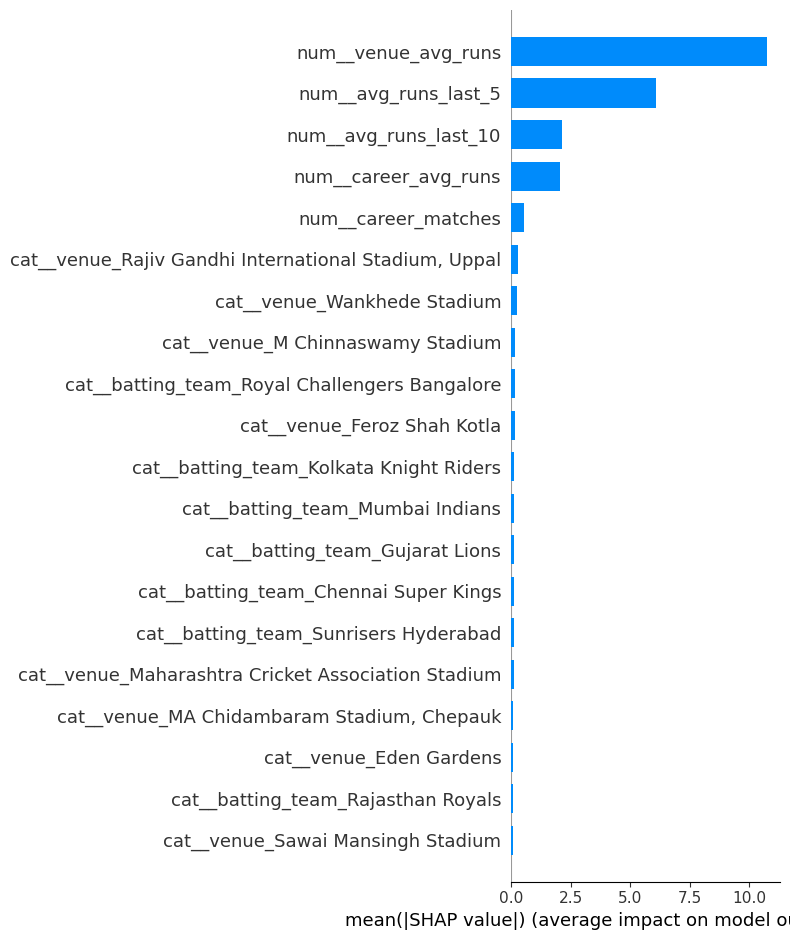

In [40]:
import shap

# Create SHAP explainer using trained model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_p)

# Plot feature importance
shap.summary_plot(
    shap_values,
    X_test_p,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="bar"
)

In [44]:
X = df[num_features + cat_features]
y = df["runs_next_match"]

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


In [46]:
X_processed = preprocessor.fit_transform(X)

In [47]:
import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    objective="reg:squarederror",
    random_state=42
)

model.fit(X_processed, y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [48]:
import joblib

joblib.dump(preprocessor, "feature_pipeline.pkl")
joblib.dump(model, "xgb_model.joblib")

['xgb_model.joblib']

In [49]:
bowler_df = pd.read_csv("../dataset_bowler.csv")

bowler_df['date'] = pd.to_datetime(bowler_df['date'])
bowler_df = bowler_df.sort_values('date')

print(bowler_df.shape)
print(bowler_df.columns.tolist())

(3024, 9)
['match_id', 'bowler', 'date', 'venue', 'wickets', 'balls', 'runs_conceded', 'economy', 'wickets_next_match']


In [50]:
NUM_FEATURES = [
    'wickets',
    'balls',
    'runs_conceded',
    'economy'
]

CAT_FEATURES = [
    'venue'
]

FEATURES = NUM_FEATURES + CAT_FEATURES
TARGET = 'wickets_next_match'

In [51]:
split_idx = int(len(bowler_df) * 0.8)

train_df = bowler_df.iloc[:split_idx]
test_df  = bowler_df.iloc[split_idx:]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test  = test_df[FEATURES]
y_test  = test_df[TARGET]

In [52]:
baseline_pred = test_df['wickets']

print("BOWLER BASELINE PERFORMANCE")
print("RMSE:", np.sqrt(mean_squared_error(y_test, baseline_pred)))
print("MAE :", mean_absolute_error(y_test, baseline_pred))
print("R2  :", r2_score(y_test, baseline_pred))

BOWLER BASELINE PERFORMANCE
RMSE: 1.4304827827469777
MAE : 1.0644628099173554
R2  : -0.907943672878817


In [53]:
preprocessor_bowler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUM_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_FEATURES)
    ]
)

X_train_p = preprocessor_bowler.fit_transform(X_train)
X_test_p  = preprocessor_bowler.transform(X_test)

In [54]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf.fit(X_train_p, y_train)

rf_pred = rf.predict(X_test_p)

print("BOWLER RANDOM FOREST")
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))
print("MAE :", mean_absolute_error(y_test, rf_pred))
print("R2  :", r2_score(y_test, rf_pred))

BOWLER RANDOM FOREST
RMSE: 1.1211934261157486
MAE : 0.8871995474222748
R2  : -0.17209108990004562


In [55]:
xgb_bowler = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    objective='reg:squarederror',
    random_state=42
)

xgb_bowler.fit(X_train_p, y_train)

xgb_pred = xgb_bowler.predict(X_test_p)

print("BOWLER XGBOOST")
print("RMSE:", np.sqrt(mean_squared_error(y_test, xgb_pred)))
print("MAE :", mean_absolute_error(y_test, xgb_pred))
print("R2  :", r2_score(y_test, xgb_pred))

BOWLER XGBOOST
RMSE: 1.0574524832487318
MAE : 0.829615099075412
R2  : -0.04261027814124341


In [56]:
lgb_bowler = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)

lgb_bowler.fit(X_train_p, y_train)

lgb_pred = lgb_bowler.predict(X_test_p)

print("BOWLER LIGHTGBM")
print("RMSE:", np.sqrt(mean_squared_error(y_test, lgb_pred)))
print("MAE :", mean_absolute_error(y_test, lgb_pred))
print("R2  :", r2_score(y_test, lgb_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 2419, number of used features: 31
[LightGBM] [Info] Start training from score 0.965275
BOWLER LIGHTGBM
RMSE: 1.0862388120987814
MAE : 0.8638071530192384
R2  : -0.10014748906649373


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


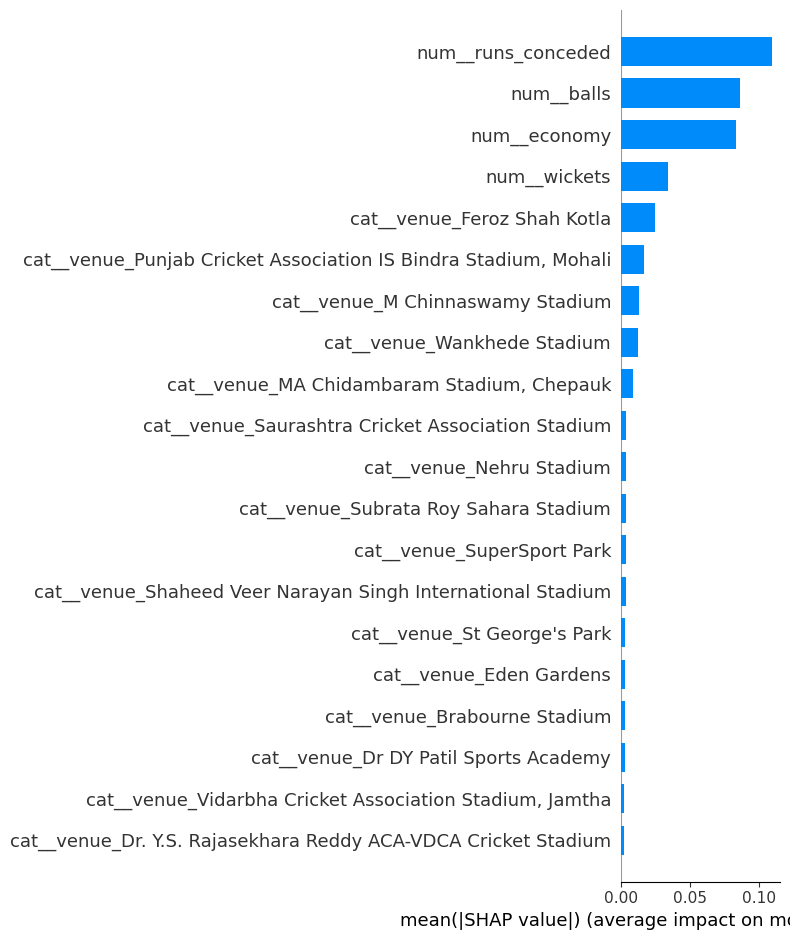

In [57]:
explainer = shap.TreeExplainer(xgb_bowler)
shap_values = explainer.shap_values(X_test_p)

shap.summary_plot(
    shap_values,
    X_test_p,
    feature_names=preprocessor_bowler.get_feature_names_out(),
    plot_type="bar"
)

In [58]:
joblib.dump(preprocessor_bowler, "../feature_pipeline_bowler.pkl")
joblib.dump(xgb_bowler, "../bowler_model.joblib")

['../bowler_model.joblib']

In [59]:
import joblib

preprocessor = joblib.load("feature_pipeline.pkl")

print("Total features:", len(preprocessor.get_feature_names_out()))
print(preprocessor.get_feature_names_out())

Total features: 55
['num__avg_runs_last_5' 'num__avg_runs_last_10' 'num__venue_avg_runs'
 'num__career_avg_runs' 'num__career_matches'
 'cat__venue_ACA-VDCA Stadium' 'cat__venue_Barabati Stadium'
 'cat__venue_Brabourne Stadium' 'cat__venue_Buffalo Park'
 'cat__venue_De Beers Diamond Oval'
 'cat__venue_Dr DY Patil Sports Academy'
 'cat__venue_Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium'
 'cat__venue_Eden Gardens' 'cat__venue_Feroz Shah Kotla'
 'cat__venue_Feroz Shah Kotla Ground' 'cat__venue_Green Park'
 'cat__venue_Holkar Cricket Stadium' 'cat__venue_IS Bindra Stadium'
 'cat__venue_JSCA International Stadium Complex' 'cat__venue_Kingsmead'
 'cat__venue_M Chinnaswamy Stadium' 'cat__venue_M. A. Chidambaram Stadium'
 'cat__venue_M. Chinnaswamy Stadium'
 'cat__venue_MA Chidambaram Stadium, Chepauk'
 'cat__venue_Maharashtra Cricket Association Stadium'
 'cat__venue_Nehru Stadium' 'cat__venue_New Wanderers Stadium'
 'cat__venue_Punjab Cricket Association IS Bindra Stadium, Mohali'
 '